In [1]:
%load_ext notexbook
%texify

# Transforms and Samplers

In this notebook we will continue to be working with our `FER` dataset.

In particular, we will start where we left off and will continue improving our abstractions by focusing on `transformers` and more sophisticated **data loading** strategies, to cope with dataset class imbalance.

Let's start by loading the dataset from `fer.py`

**Note**: if opening this notebook from Colab, please refer to this file: $\Rightarrow$ [`fer.py`](https://github.com/leriomaggio/pytorch-beautiful-ml-data/blob/main/3_transformer_samplers/fer.py)

In [2]:
# Set determinism
import torch
import numpy as np

SEED = 920

np.random.seed(SEED)

torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
from fer import FER

In [4]:
DOWNLOAD_ROOT = "./data"
fer_training = FER(root=DOWNLOAD_ROOT, download=True, split="train")

In [5]:
from collections import namedtuple
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate

Batch = namedtuple("Batch", ["samples", "emotions"])

def batch_collate_fn(batch):
    batch = default_collate(batch)
    return Batch(*batch)

In [6]:
BATCH_SIZE = 256

training_loader = DataLoader(fer_training, batch_size=BATCH_SIZE, 
                             shuffle=True, drop_last=False,
                             collate_fn=batch_collate_fn)

If we now get out first batch of data

In [7]:
batch = next(iter(training_loader))

In [8]:
batch.samples.shape

torch.Size([256, 1, 48, 48])

In [9]:
batch.emotions.shape

torch.Size([256])

## Introducing `torchvision`

With this implementation, everything is fine indeed. Plus, ultimately we are dealing with `torch.Tensor` which is **the** data format that is required by `torch.nn.Module` for training/validation.

However, what if we would apply any (`Random`?) **preprocessing** transformation to each image before it is transformed to a `torch.Tensor`; not to mention a whole pipeline of **data augmentation** ?

Each sample in the `FER` dataset is an (grayscale) image, and `torchvision` is the **PyTorch** extension specifically for computer vision. 

In particular, `torchvision` provides what it calls `Transforms`, simple `Callable` objects very easy to use and implement, that have been designed exactly with this scenario in mind. 

`torchvision.transforms` classes can be organised in three main categories:

- Transforms on `PIL.Image` **only** -- `Callable` objects
- Transforms on `torch.Tensor` **only** - `nn.Module` subclasses, and also `torch.jit.scriptable`
- Transforms on `PIL Image` and `torch.Tensor` (typically `nn.Module` subclasses)

Plus: (1) _Compositional_ transformers, and (2) _Functional_ transformers, i.e. functional versions of the OOP-based ones.

The **full list** of [`torchvision.transforms`](https://pytorch.org/docs/stable/torchvision/transforms.html) is available in the official documentation.

More on `TorchScript` here: [tutorial](https://pytorch.org/tutorials/beginner/Intro_to_TorchScript_tutorial.html)

---

Integrating a `transform` object is very easy, as it is also very easy to develop your own _custom_ transformers.

### `Dataset` and `transform`

Integrating `transforms` and preprocessing into `Dataset` is very easy, and it is also result of good data structures abstractions, once again 😊

The way we will use to integrate transforms is similar to what `datasets` included in `torchvision` do, i.e. `torchvision.datasets.VisionDataset`

In [10]:
from typing import Optional, Callable

from torchvision.datasets import VisionDataset
from PIL import Image

class FERVision(FER, VisionDataset):
    
    def __init__(self, root: str = ".", download: bool = True, split: str = "train", 
                 transform: Optional[Callable] = None) -> None:
        FER.__init__(self, root=root, download=download, split=split)
        VisionDataset.__init__(self, root=root, transform=transform)
        
    def __getitem__(self, index):
        img, target = self.data[index], int(self.targets[index])

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img.numpy(), mode="L")
        if self.transform is not None:
            img = self.transform(img)
        return img, target
    
        

Easy, eh?! 🙌

Now we will start injecting a very simple transformer, `toTensor` which transforms the input `PIL.Image` into a `torch.Tensor`.

In [11]:
import PIL
from torchvision.transforms import ToTensor, Compose, Lambda, RandomAffine

In [12]:
transform_pipeline = Compose([Lambda(lambda img: img.convert("RGB")),
                              RandomAffine(degrees=40, resample=PIL.Image.BILINEAR, fill=255), 
                              ToTensor()])

/Users/valerio/anaconda3/envs/dl-datascience/lib/python3.8/site-packages/torchvision/transforms/transforms.py:1314: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  warnings.warn(


In [13]:
fer_vision_train = FERVision(root=DOWNLOAD_ROOT, download=True, split="train", transform=transform_pipeline)

In [14]:
train_loader = DataLoader(fer_vision_train, batch_size=4, 
                          shuffle=True, drop_last=False, collate_fn=batch_collate_fn)

In [15]:
batch = next(iter(train_loader))
batch.samples.shape, batch.emotions.shape

(torch.Size([4, 3, 48, 48]), torch.Size([4]))

OK: _so far, so good_. 

Nothing has really changed apparently, apart from the fact that if we _instantiate_ the `FERVision` dataset with no `transform`, a `PIL.Image` will be returned.

---

In [16]:
from matplotlib import pyplot as plt 

%matplotlib inline

Emotions: ['fear', 'happy', 'sad', 'sad']


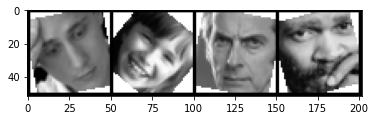

Emotions: ['fear', 'happy', 'happy', 'sad']


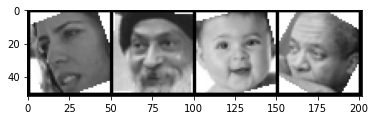

Emotions: ['neutral', 'surprise', 'fear', 'sad']


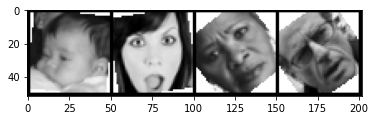

Emotions: ['surprise', 'surprise', 'happy', 'fear']


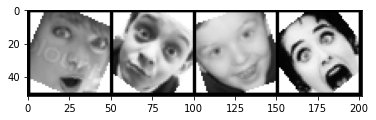

In [17]:
from torchvision.utils import make_grid

for i, batch in enumerate(train_loader):
    samples, labels = batch.samples, batch.emotions
    print(f"Emotions: {list(map(lambda e: fer_vision_train.idx_to_class[e.item()], labels))}")
    grid = make_grid(samples)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.show()
    
    if i == 3:
        break

---

## DataLoaders and Imbalanced data

As already mentioned in the previous part, the `FER` dataset is a wonderful example of imbalanced data. 

![image.png](https://raw.githubusercontent.com/leriomaggio/pytorch-beautiful-ml-data/main/3_transformer_samplers/imgs/fer_imbalance.png)

Common techniques to cope with imbalanced data usually involve:
- class weighting 
- oversampling

With the _class weighting_ we assign a weight to each class, to be passed to the optimiser, whenever it will be the time to calculate the `loss` on generated predictions. 
The general idea is to penalise **more** errors on the _least_ represented classes.

With _oversampling_, on the other hand, the idea is to try to keep the *same* number of samples in the dataset (and consequently in _batches_) for all the classes. To do so, samples from the minority classes will be _simply repeated_ and included again in the dataset, as they were "other" new samples. 

In this notebook we will discuss a bit of bot, but most importantly, we will have the chance to introduce another object abstraction used by `torch.utils.data` objects: `Sampler`

### Sampler

A `torch.utils.data.Sampler` object is a very simple objects used to specify the **map**, i.e. _the sequence of indices/keys_ used in data loading. 

In fact, a `DataLoader` objects accepts a `sampler` parameter (`None` by default) to be used in combination with the input `Dataset`.

PyTorch provides the following generic `Sampler` classes:

- [`SequentialSampler(data_source)`](https://pytorch.org/docs/stable/data.html?highlight=sequentialsampler#torch.utils.data.SequentialSampler)

- [`RandomSampler(data_source)`](https://pytorch.org/docs/stable/data.html?highlight=randomsampler#torch.utils.data.RandomSampler)

- [`SubsetRandomSampler(indices: Sequence[int], generator: torch.Generator = None)`](https://pytorch.org/docs/stable/data.html?highlight=randomsampler#torch.utils.data.SubsetRandomSampler)

- [`WeightedRandomSampler(weights: Sequence[float], num_samples, replacement, generator)`](https://pytorch.org/docs/stable/data.html?highlight=randomsampler#torch.utils.data.WeightedRandomSampler)

Their roles, and their use is pretty straightforward.

There exists also a [`BatchSampler`](https://pytorch.org/docs/stable/data.html?highlight=sequentialsampler#torch.utils.data.BatchSampler) which is used by the `DataLoader` in alternative to the `batch_size` if specified (parameter `batch_sampler`)

#### Sampling FER Data

The general idea is to use a `WeightedRandomSampler` for the _training_ data loader to cope with samples imbalance among classes.
To do so, weights for each samples should be calculated, based on their corresponding `class`.

In [18]:
# Adapted from: https://discuss.pytorch.org/t/balanced-sampling-between-classes-with-torchvision-dataloader/2703/2

import numpy as np

def weights_for_balanced_classes(fer_dataset):                        
    n_classes = len(fer_dataset.classes)
    y_true = fer_dataset.targets.cpu().numpy()

    class_count = np.bincount(y_true)
    weights = 1 / class_count[y_true]
    weights /= weights.max()
    return weights, class_count

In [19]:
weights, class_count = weights_for_balanced_classes(fer_vision_train)

In [20]:
# convert in torch tensors
weights = torch.FloatTensor(weights)
class_count = torch.FloatTensor(class_count)

In [21]:
weights

tensor([0.1091, 0.1091, 0.1064,  ..., 0.0903, 0.1091, 0.0903])

In [22]:
from torch.utils.data import WeightedRandomSampler

weighted_sampler = WeightedRandomSampler(weights, num_samples=len(weights), 
                                         replacement=True)  # implements the oversampling

In [23]:
BATCH_SIZE = 512
oversampling_loader = DataLoader(fer_vision_train, batch_size=BATCH_SIZE, 
                                 sampler=weighted_sampler, drop_last=False)

Utility function to plot the count of samples per each classes, as generated by the data loader

In [24]:
from matplotlib.pyplot import cm
color_map = cm.tab10

In [25]:
def plot_class_counts(cls_count, bar_color, title="", class_names=fer_training.classes):
    plt.title(title)
    plt.bar(range(7), cls_count, color=bar_color)
    plt.xticks(range(7), labels=class_names, rotation=90)
    plt.ylim(0, cls_count.max() + 1000)
    for i, c in enumerate(cls_count):
        plt.annotate(text=f"{c:,}", xy=(i-.25, c+200))
    plt.show()

def generate_batches(loader, max_iter: int = 10, label: str ="") -> None:
    for i, batch in enumerate(loader):
        if (i == max_iter):
            break 
        images, labels = batch
        class_count = np.bincount(labels)
        plot_class_counts(class_count, color_map(i), title=f"Class Distribution Batch-{label}-{i+1}")

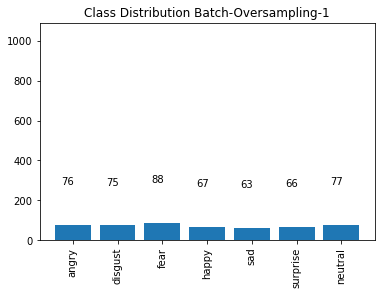

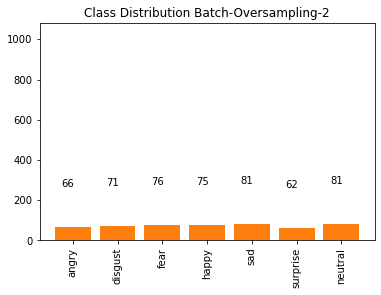

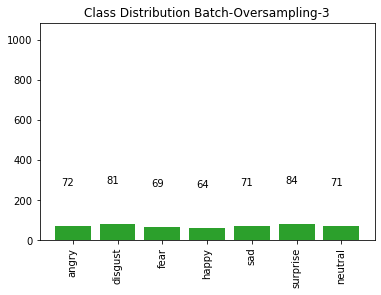

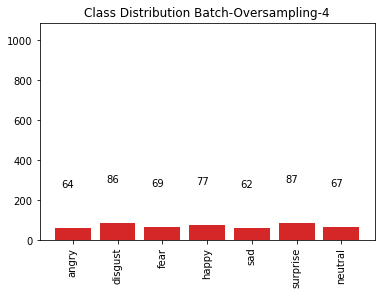

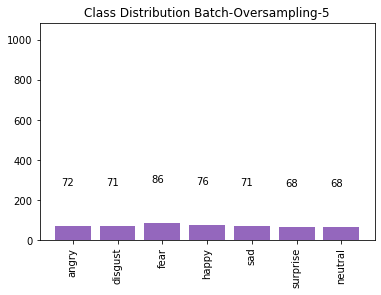

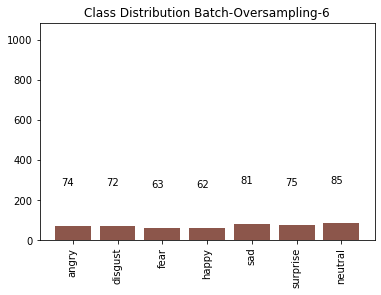

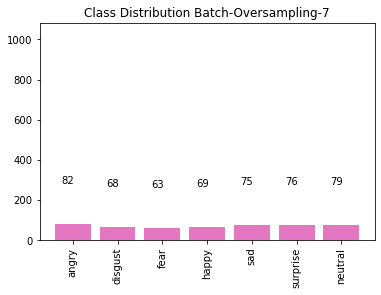

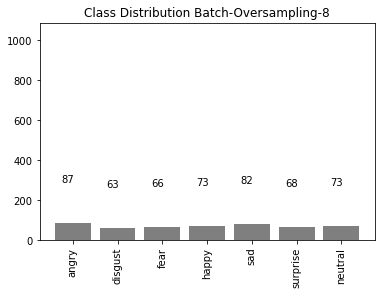

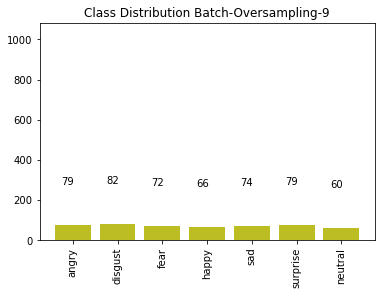

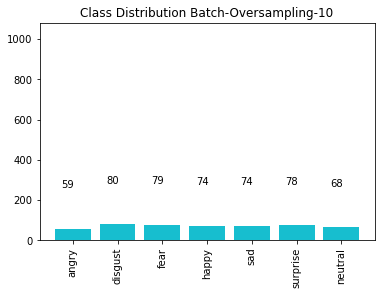

In [26]:
generate_batches(oversampling_loader, label="Oversampling")

As a counter-example, let's try to repeat the very same operations, with a `RandomSampler` (no weights) and with no `sampler` at all!

##### NO Sampler

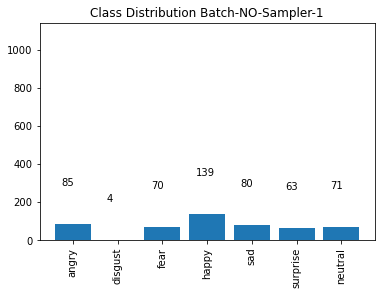

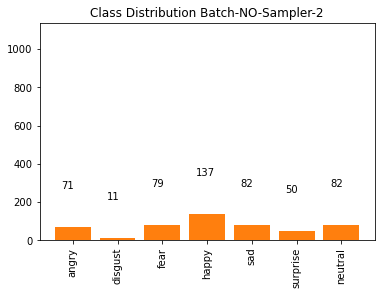

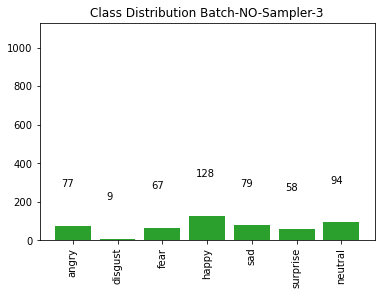

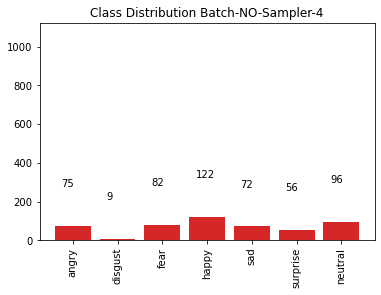

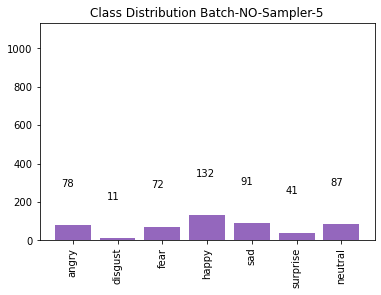

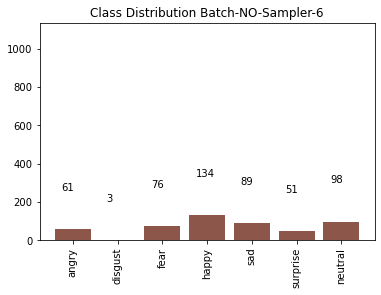

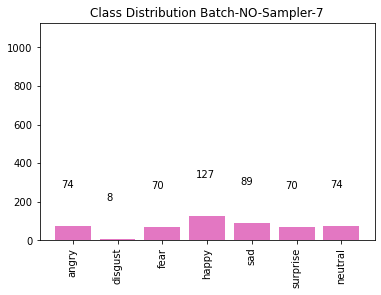

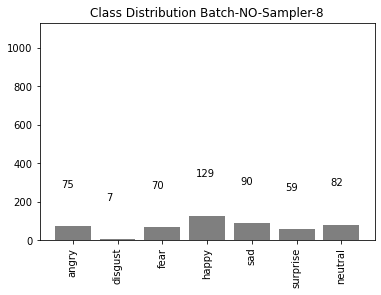

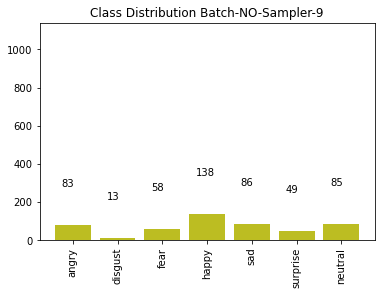

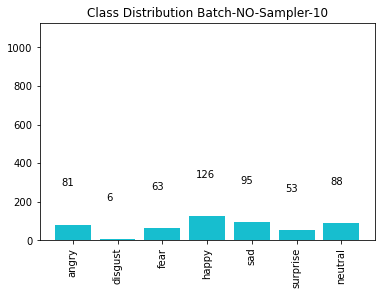

In [27]:
training_loader_no_sampler = DataLoader(fer_vision_train, batch_size=512, drop_last=False, shuffle=True)
generate_batches(training_loader_no_sampler, label="NO-Sampler")

##### Random Sampler

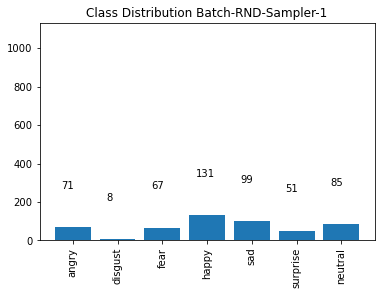

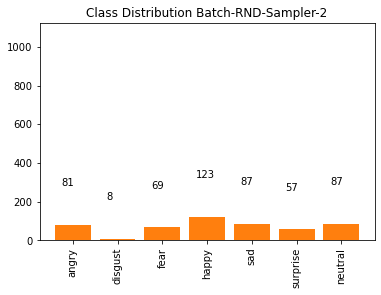

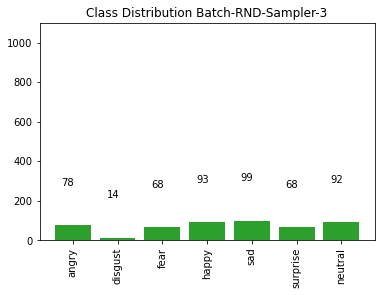

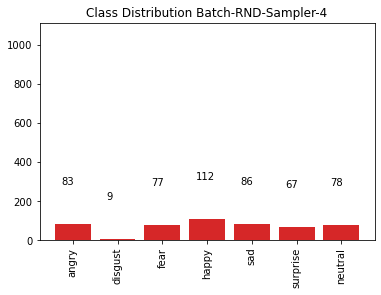

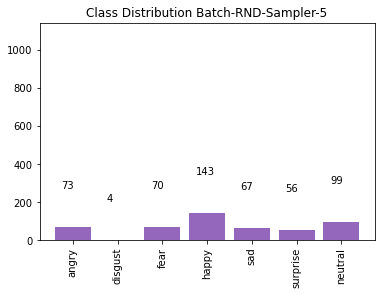

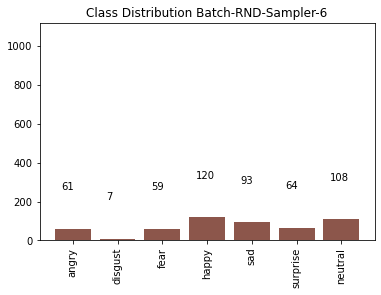

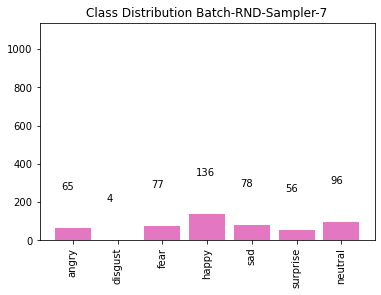

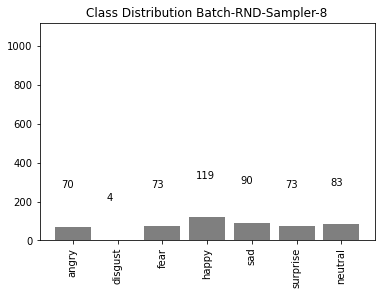

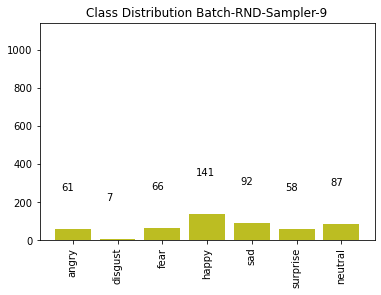

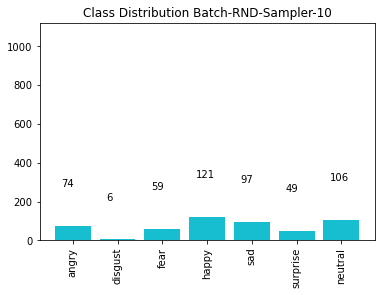

In [28]:
from torch.utils.data import RandomSampler

training_loader_rnd_sampler = DataLoader(fer_vision_train, batch_size=512,
                                         sampler=RandomSampler(fer_vision_train),
                                         drop_last=False)
generate_batches(training_loader_rnd_sampler, label="RND-Sampler")

---